# Watchdog

<IPython.core.display.Javascript object>


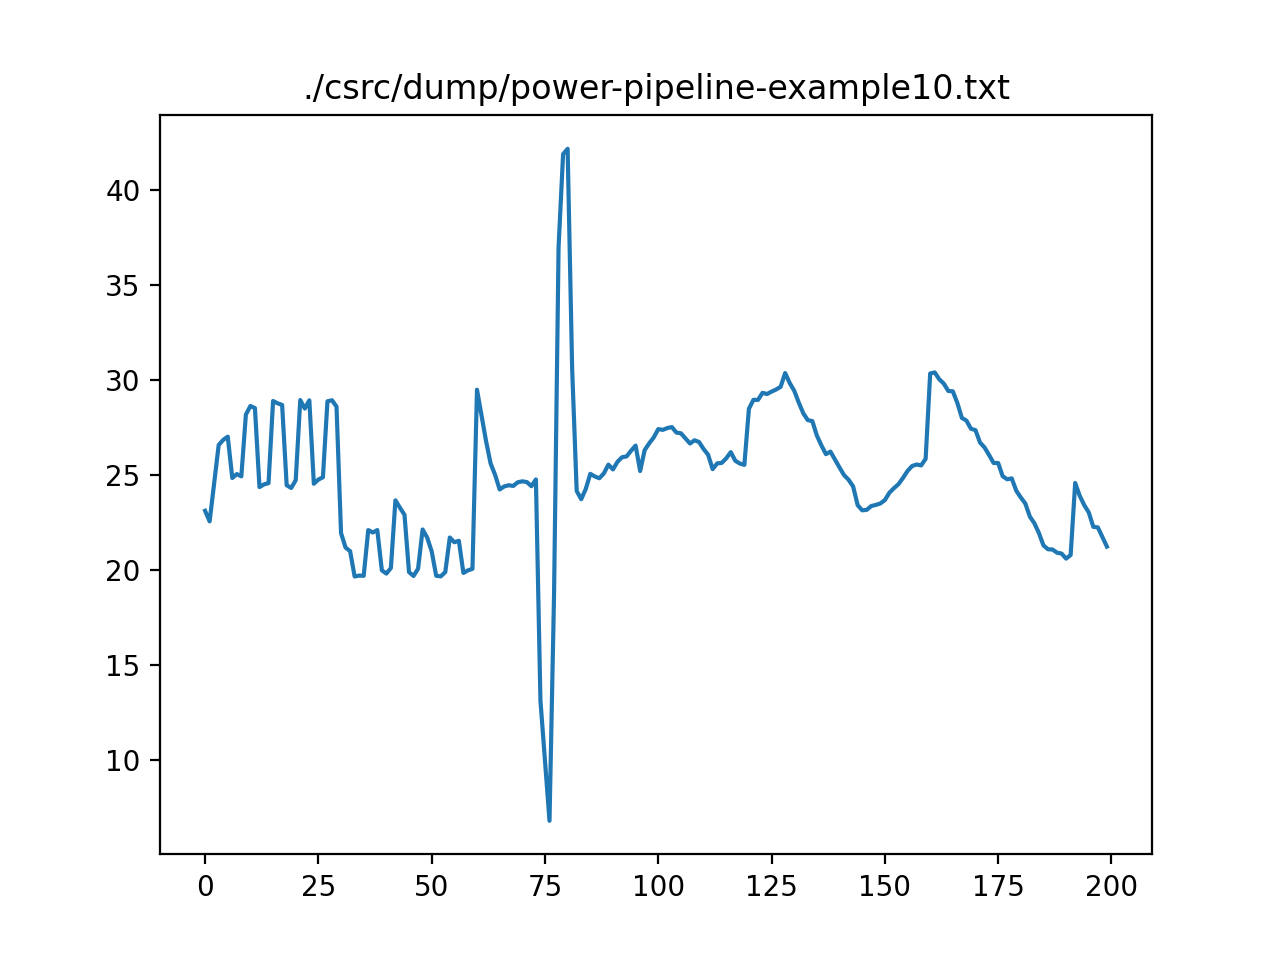

In [5]:
%matplotlib notebook
import numpy as np
from matplotlib import pyplot as plt
from watchdog.events import FileSystemEventHandler, FileSystemEvent
from watchdog.observers import Observer

SP_POINTS = 200

fig, ax = plt.subplots(1)
plot, = ax.plot([0]*SP_POINTS)
plt.show()

In [ ]:
event_handler = FileSystemEventHandler()
def my_dispatch(event: FileSystemEvent):
    if not event.is_directory:
        print(".")
        arr = np.transpose(np.loadtxt(event.src_path, skiprows=1))
        plot.set_ydata(arr[1])
        ax.relim()
        ax.autoscale_view()
        ax.set_title(event.src_path)
        plt.draw()
        plt.pause(0.1)
        
event_handler.on_modified = my_dispatch

observer = Observer()
observer.schedule(event_handler, "./csrc/dump")
observer.start()

try:
    while observer.is_alive():
        observer.join(1)
except KeyboardInterrupt:
    observer.stop()
observer.join()

.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.
.


# Building

## Check memory allocation

In [2]:
from python_app.utils import gpu_utils
import subprocess
import os

from python_app.utils.terminal_colour import TerminalColour

R_POINTS = 254000
R_POINTS_PER_CHUNK = 1000
# R_POINTS = 200
# R_POINTS_PER_CHUNK = 100
SP_POINTS = 200

def HANDLE_CPP_ERROR(result: int):
    if (result != 0):
        with open("libia.log", "r") as fin:
            for line in fin:
                pass
            print(f"{TerminalColour.FAIL}Error in CPP function:{TerminalColour.ENDC} {line}")

In [3]:
# p = subprocess.run(
#     "./csrc/bin/run", shell=True,
#     stdout=subprocess.PIPE, text=True
# )
# print(p.stdout)

In [4]:
# Build and remove logs
p = subprocess.run(
    "cd csrc && make --no-print-directory lib", shell=True,
    stdout=subprocess.PIPE, text=True,
    env={ 
        **os.environ,
        "R_POINTS": f"{R_POINTS}",
        "R_POINTS_PER_CHUNK": f"{R_POINTS_PER_CHUNK}",
        "SP_POINTS": f"{SP_POINTS}"
    }
)
print(p.stdout)

try:
    os.remove("libia.log")
except: 
    pass

🗑  Cleaning build objects
removed ‘./build/src/logging.o’
removed ‘./build/src/power_kernel_cpu.o’
removed ‘./build/src/power_kernel_gpu.o’
removed ‘./build/src/power_kernel_gpu_utils.o’
removed ‘./build/src/power_pipeline.o’
removed ‘./build/src/progress_bar.o’
removed ‘./build/src/sp_digitiser.o’
removed ‘./build/src/utils_gpu.o’
removed ‘./build/src/utils.o’
✅ [***] Done

Using flags: -D PYTHON=1 -D SP_POINTS=200 -D R_POINTS=254000 -D R_POINTS_PER_CHUNK=1000

🍕 [cpp] Building src/utils.cpp ⟶ build/./src/utils.o
🍕 [cpp] Building src/sp_digitiser.cpp ⟶ build/./src/sp_digitiser.o
🍕 [cpp] Building src/progress_bar.cpp ⟶ build/./src/progress_bar.o
🍕 [cpp] Building src/power_kernel_gpu_utils.cpp ⟶ build/./src/power_kernel_gpu_utils.o
🍕 [cpp] Building src/utils_gpu.cpp ⟶ build/./src/utils_gpu.o
🍕 [cpp] Building src/power_kernel_cpu.cpp ⟶ build/./src/power_kernel_cpu.o
🍕 [cpp] Building src/logging.cpp ⟶ build/./src/logging.o
🍕 [cpp] Building src/power_pipeline.cpp ⟶ build/./src/power_pipeli

In [5]:
# Loading of library
import ctypes
from python_app.utils import  gpu_utils

try:
    libia = ctypes.cdll.LoadLibrary("./bin/libia.so")
except Exception as err:
    raise RuntimeError(
        f"Failed to load the custom photon-counting library - make sure that it has been built!: {err}"
    )
# Check parameters that kernel was compiled with - some checks are easier to do in python.
libia.check_power_kernel_parameters()
gpu_utils.check_gpu_allocation(
    **{
        "grid_dim_x": libia.fetch_power_kernel_blocks(),
        "block_dim_x": libia.fetch_power_kernel_threads()
    }
)

In [6]:
# Setup digitiser
from python_app.sp_digitiser import SpDigitiser

sp_digitiser_parameters = {
    "r_points": R_POINTS,
    "sp_points": SP_POINTS,
    "delay": 0,
    "trigger_type": SpDigitiser.TRIGGER_EXTERNAL,
#     "trigger_type": SpDigitiser.TRIGGER_SOFTWARE,
    "channelA_gain": 1,
    "channelB_gain": 1,
    "channelA_offset": 0,
    "channelB_offset": 0,
    "clock_source": SpDigitiser.INTERNAL_CLOCK_SOURCE_INTERNAL_10MHZ_REFFERENCE,
    "frequency_mode": SpDigitiser.HIGH_FREQUENCY_MODE
}
spd = SpDigitiser(sp_digitiser_parameters, libia)

# ADQAPI = ctypes.cdll.LoadLibrary("libadq.so")
# ADQAPI.CreateADQControlUnit.restype = ctypes.c_void_p
# ADQAPI.ADQ214_GetRevision.restype = ctypes.c_void_p
# ADQAPI.ADQControlUnit_FindDevices.argtypes = [ctypes.c_void_p]

# adq_cu_ptr = ctypes.c_void_p(ADQAPI.CreateADQControlUnit())
# no_of_devices = int(ADQAPI.ADQControlUnit_FindDevices(adq_cu_ptr))
# assert no_of_devices > 0, "No devices found! Make sure all programs refferencing devices are closed and that the box is switched on. When rebooting, turn the pc on after the digitiser."

SP-DIGITISER:   Trigger frequency: 1300kHz


False

In [15]:
import threading
import time
cpp_thread = threading.Thread(target=libia.run_power_measurements, 
                              name="Power Kernel Runner", 
                              args=(spd.adq_cu_ptr, 10, ctypes.create_string_buffer(b'python-test',size=20)))
cpp_thread.start()
print("Skipped!")
while(True):
    time.sleep(2)
    if not cpp_thread.is_alive():
        break
    print("-")

Skipped!
-
-
-
-
-


In [9]:
# Launch power measurements
libia.run_power_measurements.argtypes = [ctypes.c_void_p, ctypes.c_ulong, ctypes.c_char_p]
HANDLE_CPP_ERROR(
    libia.run_power_measurements(spd.adq_cu_ptr, 100, ctypes.create_string_buffer(b'python-test',size=20))
)    

In [ ]:
spd.release()

# Power measurements
- `Period`: Number of points (each one 2.5ns) in a single pulse sequence
- `N`: Number periods to look at
- `NP = Period * N`
- `Repetition (R)`: How many times `NP` is repeated for this measurement

`TOTAL_NUMBER_OF_POINTS = R*NP`

##### Averaging
The array of values from digitiser is cast into a 2D array of dimension `NP x R`, and each column of length `R` is summed up

In [4]:
raw_paramters = {
    "RECORD_LENGTH": 65536, # Read this parameter from SP-devices
    "DEVICE_PRECISION": 14, # 14 bit precision from -ve to +ve
    "PROCESSING_ARRAY_TYPE": np.int32,
    "INPUT_ARRAY_TYPE": np.int16,
    "OUTPUT_ARRAY_TYPE": np.float32,
    "N": 8,
    "PERIOD_IN_NS": 160
}


derived_parameters = {}
derived_parameters["MAX_DEVICE_CODE"] = 2**(raw_paramters["DEVICE_PRECISION"] - 1)

# We will sum up all repetitions and then take average. This makes sure that the allocate processing array is able to store the max value
derived_parameters["STORAGE_PRECISION"] = np.dtype(raw_paramters['PROCESSING_ARRAY_TYPE']).itemsize
derived_parameters["MAX_STORE_CODE"] = 2**(derived_parameters["STORAGE_PRECISION"] * 8 - 1)

derived_parameters["P"] = int(raw_paramters["PERIOD_IN_NS"] // 2.5)
derived_parameters["SP_POINTS"] = raw_paramters["N"] * derived_parameters["P"]
derived_parameters["R_POINTS"] = raw_paramters["RECORD_LENGTH"] // derived_parameters["SP_POINTS"]
derived_parameters["TOTAL_POINTS"] = derived_parameters["R_POINTS"] * derived_parameters["SP_POINTS"]

# Allocate blocks and threads
derived_parameters["BLOCKS"] = min(GPU_PARAMETERS["grid_dim_x"], derived_parameters["SP_POINTS"])
derived_parameters["THREADS_PER_BLOCK"] = min(GPU_PARAMETERS["threads_per_block"], derived_parameters["R_POINTS"])
                                   
power_kernel_parameters = {
    **raw_paramters, **derived_parameters
}

max_store_value = power_kernel_parameters["MAX_DEVICE_CODE"] * power_kernel_parameters["R_POINTS"]

if max_store_value > power_kernel_parameters["MAX_STORE_CODE"]:
    raise RuntimeError(
        f"Max summation over repetitions (={max_store_value} bytes) cannot be stored using (STORAGE_PRECISION={power_kernel_parameters['STORAGE_PRECISION']})"
    )
    
pk = PowerKernel(power_kernel_parameters)

POWER-KERNEL:                                       Loaded following parameters:
{
    "RECORD_LENGTH": 65536,
    "DEVICE_PRECISION": 14,
    "PROCESSING_ARRAY_TYPE": "<class 'numpy.int32'>",
    "INPUT_ARRAY_TYPE": "<class 'numpy.int16'>",
    "OUTPUT_ARRAY_TYPE": "<class 'numpy.float32'>",
    "N": 8,
    "PERIOD_IN_NS": 160,
    "MAX_DEVICE_CODE": 8192,
    "STORAGE_PRECISION": 4,
    "MAX_STORE_CODE": 2147483648,
    "P": 64,
    "SP_POINTS": 512,
    "R_POINTS": 128,
    "TOTAL_POINTS": 65536,
    "BLOCKS": 512,
    "THREADS_PER_BLOCK": 128
}


In [ ]:
from ctypes import cdll
libia = cdll.LoadLibrary("/usr/lib/libia.os")

#libia = cdll.LoadLibrary("build/libia.os")

In [4]:
from ctypes import cdll
libia = cdll.LoadLibrary("./build/libia.os")
sp_digitiser_parameters = {}
spd = SpDigitiser(sp_digitiser_parameters)

print(libia.GetMaxNofSamplesFromNofRecords(spd.adq_cu_ptr, 128))
print(libia.GetMaxNofRecordsFromNofSamples(spd.adq_cu_ptr, 128))

254200
254200


In [8]:
ADQAPI = cdll.LoadLibrary("libadq.so")
# spd.blink()

a = 1
b = 0
# ADQAPI.ADQ214_GetMaxNofSamplesFromNofRecords(
#     spd.adq_cu_ptr, 1, a, b
# )

In [ ]:
ADQAPI.ADQ214_GetMaxNofSamplesFromNofRecords()

In [4]:


sp_digitiser_parameters = {
    "samples_per_record": 65536,
    "number_of_records": 1,
    "trigger": SpDigitiser.TRIGGER_EXTERNAL
}
sp_digitiser_parameters

{'samples_per_record': 65536, 'number_of_records': 1, 'trigger': 1}

In [3]:

DEVICE_a_array = cuda.to_device(a_array)
DEVICE_b_array = cuda.to_device(b_array)
DEVICE_out_array = cuda.device_array(
    shape=(total_paramters["SP_POINTS"]),
    dtype=total_paramters["OUTPUT_ARRAY_TYPE"],
)

In [31]:
pk.kernel(DEVICE_a_array, DEVICE_b_array, DEVICE_out_array)
out_array = DEVICE_out_array.copy_to_host()

{'RECORD_LENGTH': 65536,
 'DEVICE_PRECISION': 14,
 'STORAGE_TYPE': int32,
 'N': 3,
 'PERIOD_IN_NS': 200,
 'MAX_DEVICE_CODE': 8192,
 'STORAGE_PRECISION': 32,
 'MAX_STORE_CODE': 2147483648,
 'P': 81,
 'NP': 243,
 'R': 269,
 'TOTAL_POINTS': 65367}

In [3]:
from utils.info import gpu_check

gpu_check()

{'max_shared_memory_per_block': 49152,
 'max_threads_per_block': 1024,
 'max_block_dim_x': 1024,
 'max_block_dim_y': 1024,
 'max_block_dim_z': 64,
 'max_grid_dim_x': 2147483647,
 'max_grid_dim_y': 65535,
 'max_grid_dim_z': 65535}

# Legacy

In [1]:
from utils.array_stacker import ArrayStacker
from kernels.potential_minimum_searcher import PotentialMinimumSearcher
from kernels.potential_evaluator import PotentialEvaluator
from functions.potential import potential_function_cuda
from common import plotter
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from numba.cuda.cudadrv.devicearray import DeviceNDArray
from numba import cuda
import numpy as np
import math
import itertools
from collections import defaultdict
from typing import Tuple, List, Dict
from utils.info import allocate_max_threads, verify_blocks_per_grid


pi = math.pi
sin = np.sin
cos = np.cos

plt.style.use('my_official')